In [1]:
from scipy.io import mmread
import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import leidenalg as la
import igraph as ig

In [2]:
data_path = './data'

enron_path = f'{data_path}/email_enron_only.mtx'
univ_path = f'{data_path}/email_univ.edges'


In [3]:
# assume undirected graph
def read_adj_file(file, skip_rows: int = 0):
    lines = []
    with open(file, 'r') as f:
        lines = f.readlines()

    E = np.asarray([l.split() for l in lines[skip_rows:]]).astype(int)
    # index from 0
    E = E - E.min()

    adj = np.zeros((E.max() + 1, E.max() + 1))

    for (u,v) in E:
        adj[u, v] = 1
        adj[v, u] = 1

    return adj


# Load datasets

In [4]:
# not in standard mtx format
g_univ = nx.Graph(read_adj_file(univ_path))
g_univ.number_of_nodes(), g_univ.number_of_edges(), g_univ.is_directed()

(1133, 5451, False)

In [5]:
mmread(enron_path)

<143x143 sparse matrix of type '<class 'numpy.float64'>'
	with 1246 stored elements in COOrdinate format>

In [6]:
g_enron = nx.Graph(mmread(enron_path).toarray())
g_enron.number_of_nodes(), g_enron.number_of_edges(), g_enron.is_directed()

(143, 623, False)

In [7]:
g_karate = nx.karate_club_graph()
g_karate.number_of_nodes(), g_karate.number_of_edges(), g_karate.is_directed()

(34, 78, False)

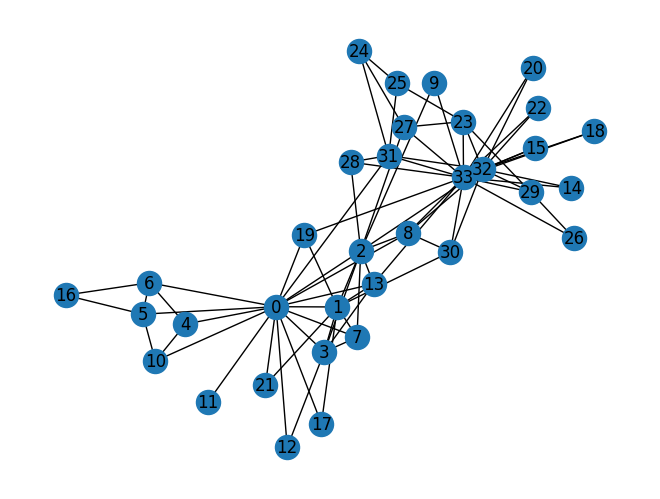

In [8]:
nx.draw(g_karate, with_labels=True)

# Define Metrics for comparison

In [9]:
def community_metrics(graph, labels):
    """
    Calculate community metrics for a given graph and set of labels.

    Parameters:
    - graph: The input graph (NetworkX graph object).
    - labels: A dictionary mapping node IDs to community labels.

    Returns:
    - A dictionary containing the calculated metrics:
        - "Modularity": The modularity score of the community partition.
        - "Number of Communities": The number of detected communities.
        - "Average Community Size": The average size of the communities.
    """
    # Group nodes by community
    communities = {}
    for node, label in labels.items():
        if label not in communities:
            communities[label] = []
        communities[label].append(node)
    community_list = list(communities.values())

    # Calculate modularity
    mod = nx.algorithms.community.modularity(graph, community_list)

    # Coverage and performance
    coverage, performance = nx.algorithms.community.partition_quality(graph, community_list)
    
    # Number of communities
    num_communities = len(community_list)
    
    # Average community size
    avg_community_size = sum(len(community) for community in community_list) / num_communities
    
    return {
        "Number of Communities": num_communities,
        "Average Community Size": avg_community_size,
        "Modularity": mod,
        "Coverage": coverage,
        "Performance": performance,
    }

# Plotting of resulting communities

In [77]:
def plot_communities(G, node_community_labels, title="Communities"):
    plt.figure(figsize=(15, 7))
    pos = nx.spring_layout(G, seed=42)

    if not isinstance(node_community_labels, np.ndarray):
        node_community_labels = list(node_community_labels.values())
    nx.draw(G, pos, node_color=node_community_labels, with_labels=True, cmap=plt.cm.Set3)
    plt.title(title)

    plt.show()

# Apply Label Propagation

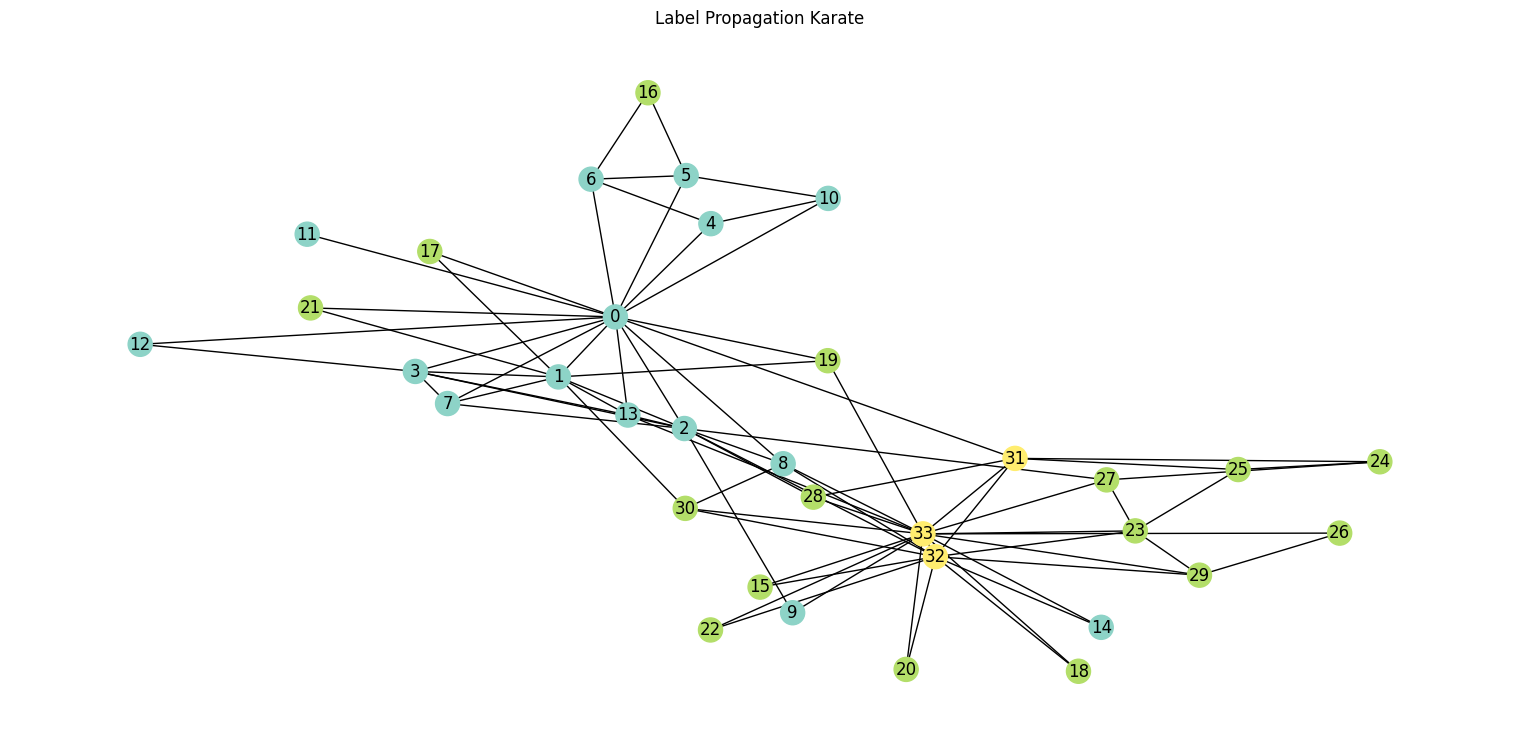

{'Number of Communities': 3,
 'Average Community Size': 11.333333333333334,
 'Modularity': 0.30948632896684847,
 'Coverage': 0.7692307692307693,
 'Performance': 0.6684491978609626}

In [11]:
lp_communities = nx.algorithms.community.label_propagation_communities(g_karate)
lp_labels = {}
for i, community in enumerate(lp_communities):
    for node in community:
        lp_labels[node] = i

plot_communities(g_karate, lp_labels, title="Label Propagation Karate")

# Calculate metrics for Louvain
lp_metrics = community_metrics(g_karate, lp_labels)
lp_metrics

# Apply Louvain

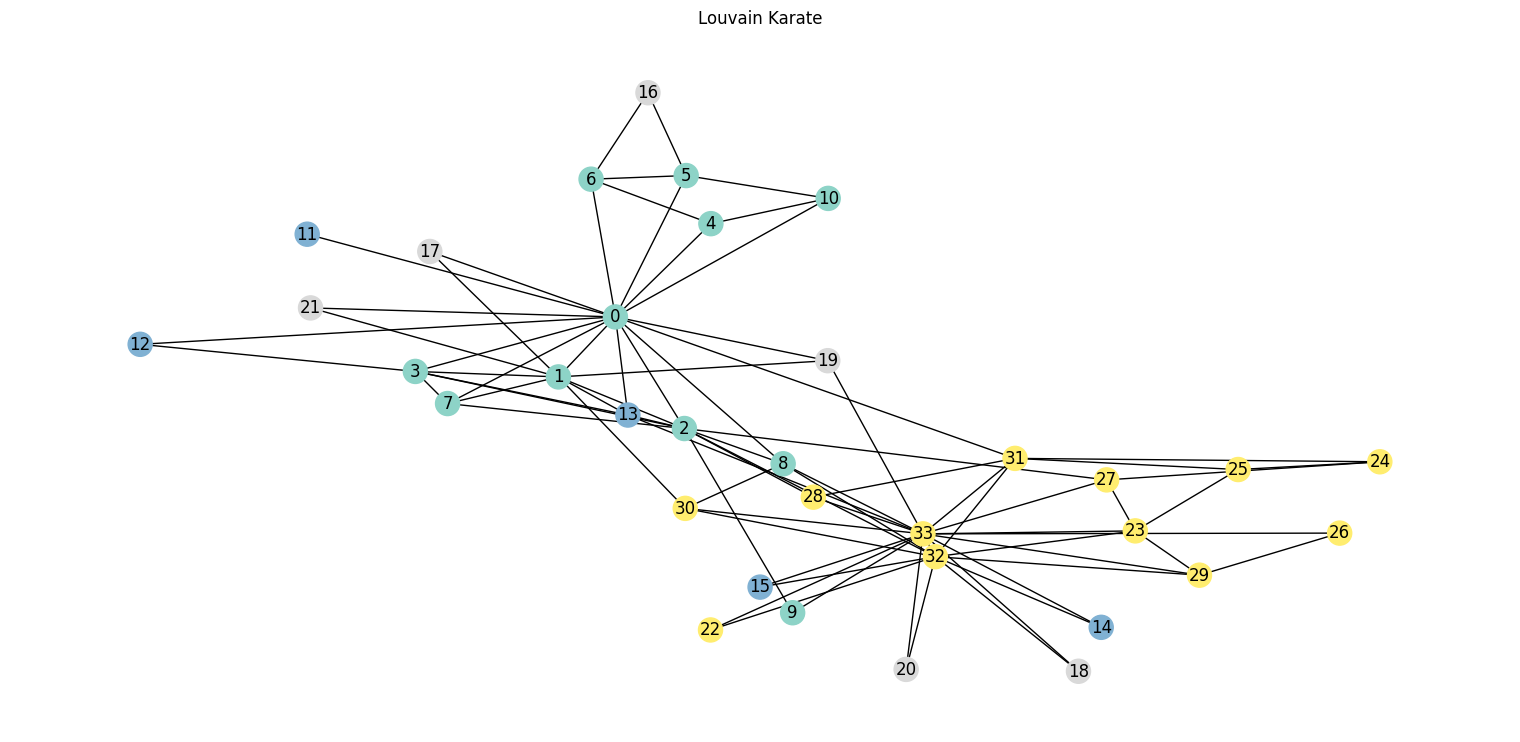

{'Number of Communities': 4,
 'Average Community Size': 8.5,
 'Modularity': 0.44490358126721763,
 'Coverage': 0.7307692307692307,
 'Performance': 0.803921568627451}

In [12]:
lv_communities = nx.algorithms.community.louvain_communities(g_karate)
lv_labels = {}

# if str(type(lv_communities)) == "<class 'generator'>":
#     lv_communities = [c for c in lv_communities][-1]

for i, community in enumerate(lv_communities):
    for node in community:
        lv_labels[node] = i

plot_communities(g_karate, lv_labels, title="Louvain Karate")

# Calculate metrics for Louvain
lv_metrics = community_metrics(g_karate, lv_labels)
lv_metrics


# Apply Leiden

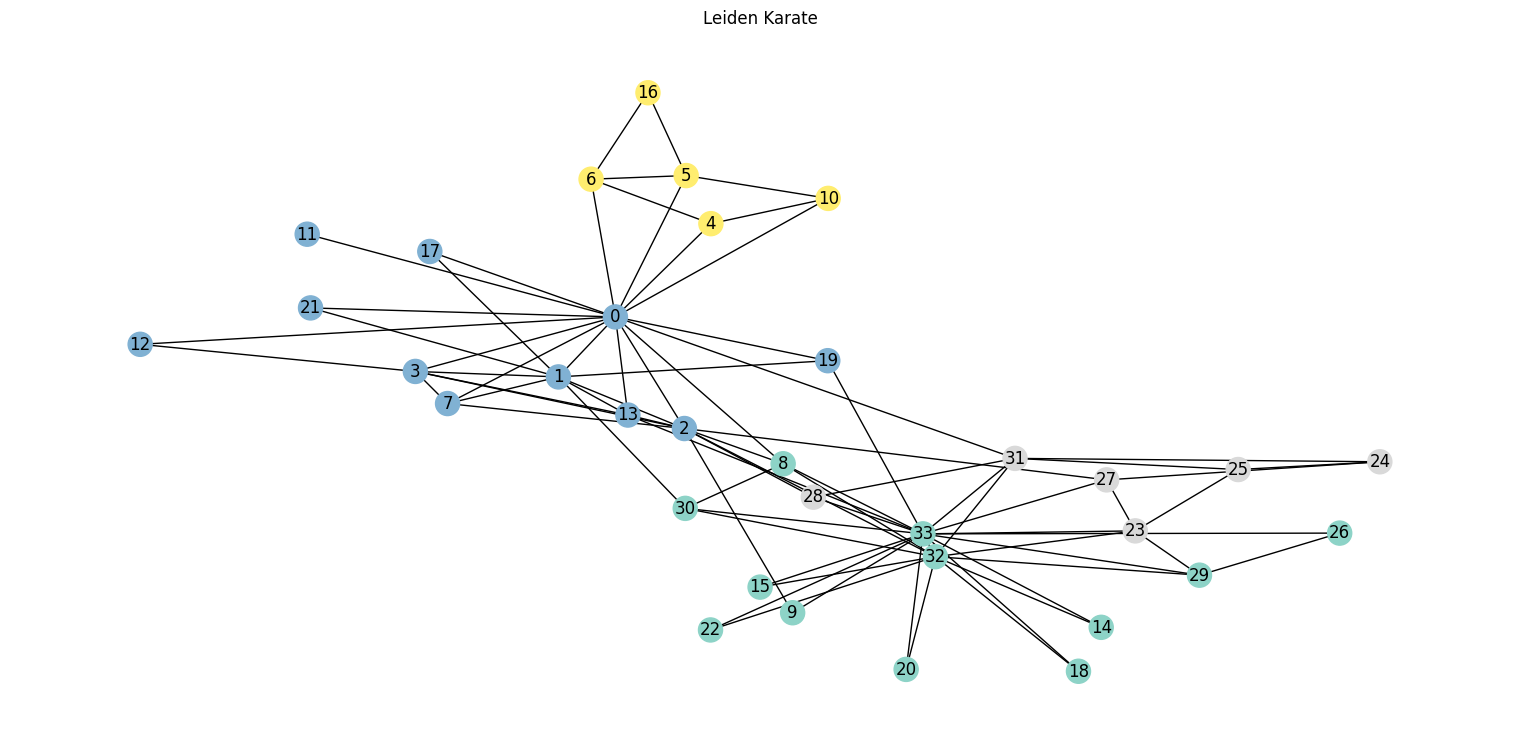

{'Number of Communities': 4,
 'Average Community Size': 8.5,
 'Modularity': 0.44490358126721763,
 'Coverage': 0.7307692307692307,
 'Performance': 0.803921568627451}

In [13]:
ig_graph = ig.Graph.from_networkx(g_karate)
leiden_partition = la.find_partition(ig_graph, la.RBConfigurationVertexPartition)
ld_labels = {node: part for node, part in zip(g_karate.nodes(), leiden_partition.membership)}

plot_communities(g_karate, ld_labels, title="Leiden Karate")

# Calculate metrics for Louvain
ld_metrics = community_metrics(g_karate, ld_labels)
ld_metrics

# node2vec

In [14]:
from node2vec import Node2Vec

/home/jann/GAT/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [141]:
node2vec = Node2Vec(g_karate, dimensions=8, walk_length=30, num_walks=50, workers=4) 

# Embed nodes
node2vec_model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)


Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 2333.75it/s]


Generating walks (CPU: 2): 100%|██████████| 13/13 [00:00<00:00, 74.75it/s]


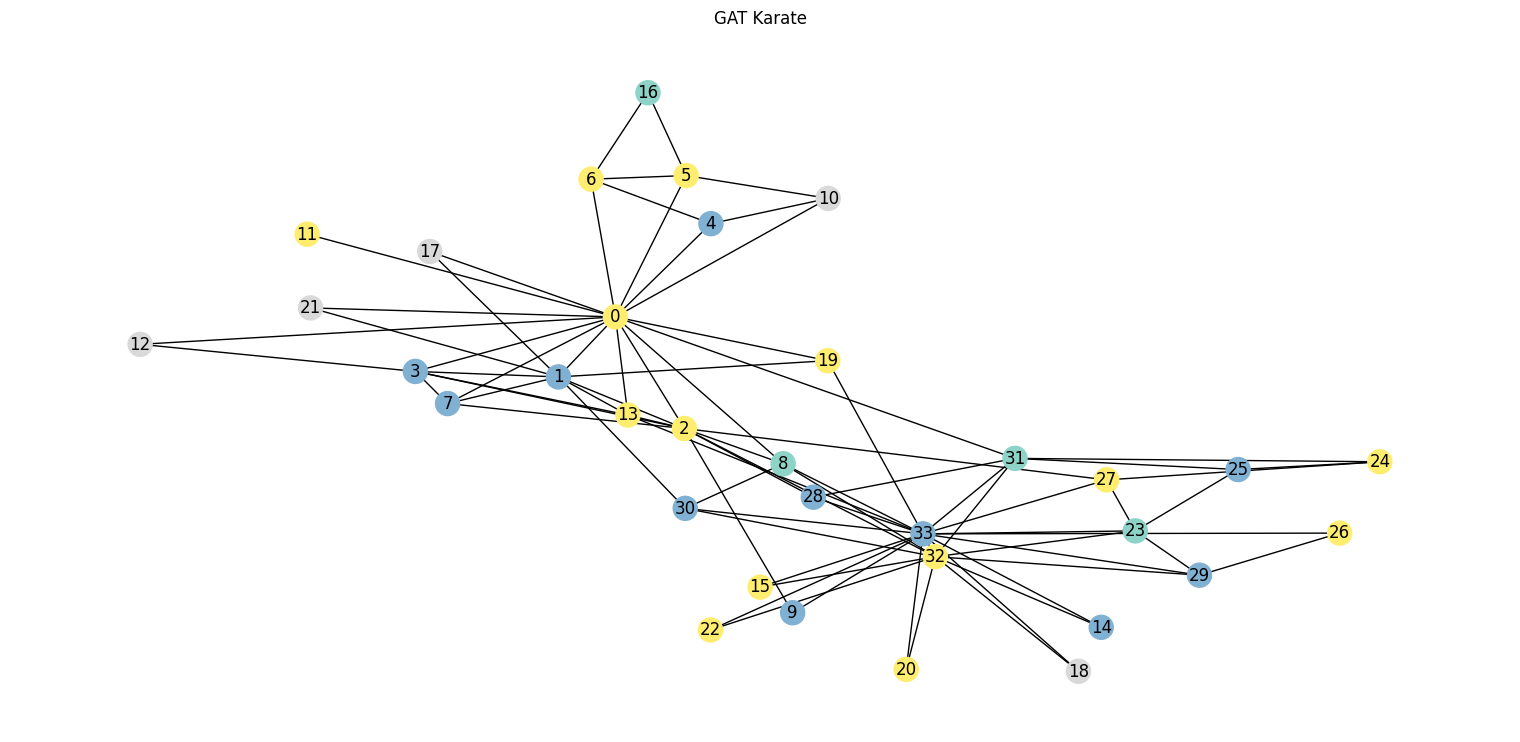

{'Number of Communities': 4,
 'Average Community Size': 8.5,
 'Modularity': -0.07365866456775547,
 'Coverage': 0.2948717948717949,
 'Performance': 0.6541889483065954}

In [142]:
from sklearn.cluster import KMeans

num_communities = 4  # Set the number of communities
kmeans = KMeans(n_clusters=num_communities)
community_labels = kmeans.fit_predict(node2vec_model.wv.get_normed_vectors())
# community_labels = kmeans.fit_predict(embeddings)


plot_communities(g_karate, community_labels, title="GAT Karate")
community_metrics(g_karate, dict(zip(range(g_karate.number_of_nodes()), community_labels)))


# Apply GAT Embedding

In [16]:
import os
os.environ["DGLBACKEND"] = "pytorch"

# GAT

In [26]:
adj = nx.to_scipy_sparse_array(g_karate)

In [38]:
import torch
from torch_geometric.data import Data

# Convert adjacency matrix to edge list
edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)

# Assuming node_features is already defined
# If not, initialize with an identity matrix
node_features = torch.from_numpy(node2vec_model.wv.get_normed_vectors())

# Create the PyTorch Geometric data object
data = Data(x=node_features, edge_index=edge_index)

In [71]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index): 
        # x, edge_index = data.x, edge_index if edge_index is not None else data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.gat1(x, edge_index)
        return F.log_softmax(x, dim=1)


In [74]:
from torch_geometric.nn import DeepGraphInfomax


def corruption(x, edge_index):
    # print(f"Original x shape: {x.x.shape}")
    return x[torch.randperm(x.size(0))], edge_index


out_channels = 32
encoder = GAT(node_features.size(1), out_channels)
model = DeepGraphInfomax(
    hidden_channels=out_channels, 
    encoder=encoder, 
    summary=lambda z,
    *args, 
    **kwargs: torch.sigmoid(z.mean(dim=0)),
    corruption=corruption)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    pos_z, neg_z, summary = model(data.x, data.edge_index)
    loss = model.loss(pos_z, neg_z, summary)
    loss.backward()
    optimizer.step()
    return loss.item()


for epoch in range(200):
    loss = train()
    print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')

Epoch 1, Loss: 1.3861
Epoch 2, Loss: 1.3802
Epoch 3, Loss: 1.3870
Epoch 4, Loss: 1.3806
Epoch 5, Loss: 1.3829
Epoch 6, Loss: 1.3908
Epoch 7, Loss: 1.3832
Epoch 8, Loss: 1.3848
Epoch 9, Loss: 1.3852
Epoch 10, Loss: 1.3843
Epoch 11, Loss: 1.3742
Epoch 12, Loss: 1.3813
Epoch 13, Loss: 1.3769
Epoch 14, Loss: 1.3716
Epoch 15, Loss: 1.3879
Epoch 16, Loss: 1.3841
Epoch 17, Loss: 1.3740
Epoch 18, Loss: 1.3755
Epoch 19, Loss: 1.3823
Epoch 20, Loss: 1.3823
Epoch 21, Loss: 1.3767
Epoch 22, Loss: 1.3833
Epoch 23, Loss: 1.3808
Epoch 24, Loss: 1.3856
Epoch 25, Loss: 1.3897
Epoch 26, Loss: 1.3712
Epoch 27, Loss: 1.3883
Epoch 28, Loss: 1.3826
Epoch 29, Loss: 1.3964
Epoch 30, Loss: 1.3857
Epoch 31, Loss: 1.3734
Epoch 32, Loss: 1.3796
Epoch 33, Loss: 1.3930
Epoch 34, Loss: 1.3802
Epoch 35, Loss: 1.3850
Epoch 36, Loss: 1.3921
Epoch 37, Loss: 1.3858
Epoch 38, Loss: 1.3566
Epoch 39, Loss: 1.3709
Epoch 40, Loss: 1.3799
Epoch 41, Loss: 1.3701
Epoch 42, Loss: 1.3971
Epoch 43, Loss: 1.3877
Epoch 44, Loss: 1.38

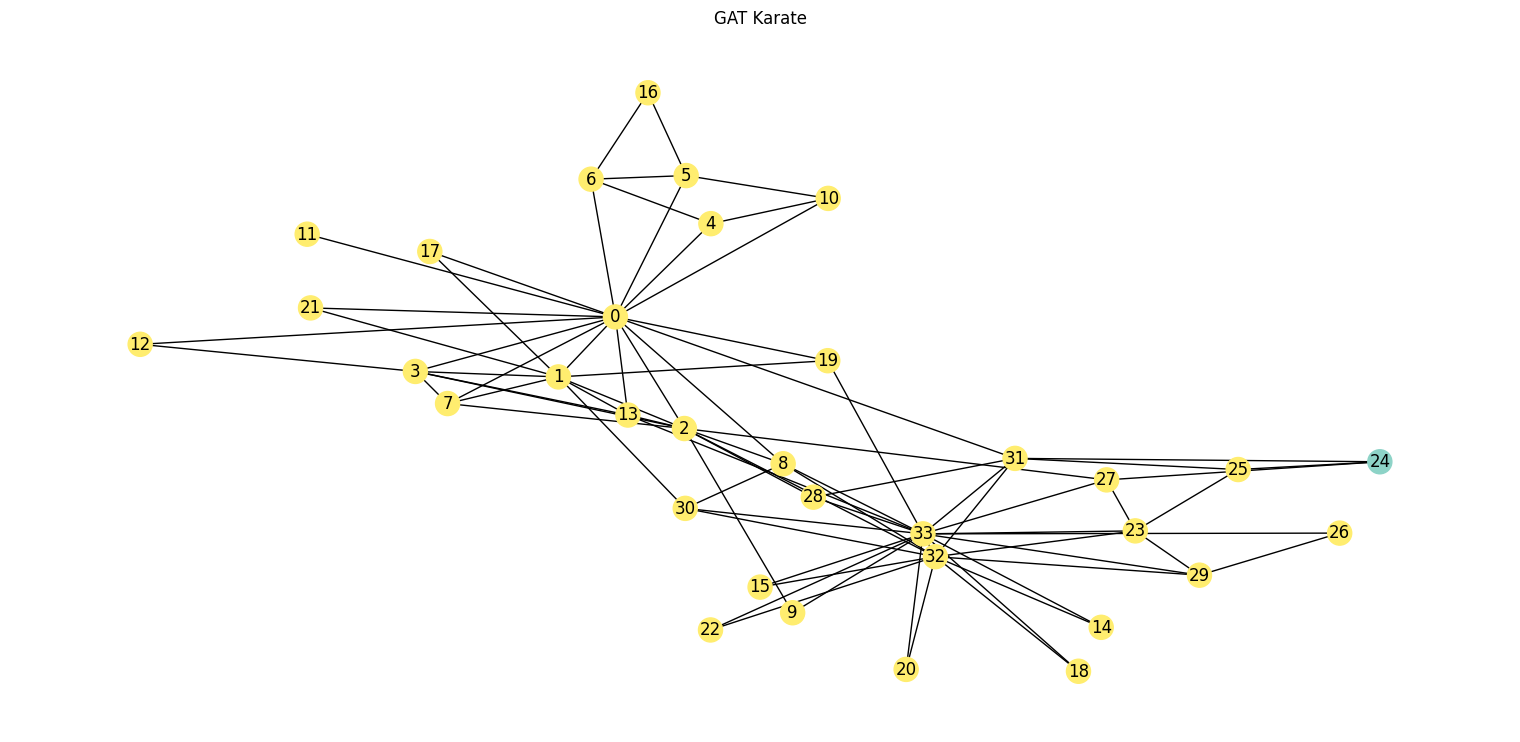

{'Number of Communities': 2,
 'Average Community Size': 17.0,
 'Modularity': -0.00045913682277314244,
 'Coverage': 0.9615384615384616,
 'Performance': 0.18716577540106952}

In [100]:
from sklearn.cluster import DBSCAN

# Get the embeddings from the trained model
model.eval()
with torch.no_grad():
    z, _, _ = model(data.x, data.edge_index)
    embeddings = z.cpu().numpy()

# Apply DBSCAN for clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples based on your data
community_labels = dbscan.fit_predict(embeddings)


plot_communities(g_karate, community_labels, title="GAT Karate")

# Calculate metrics for Louvain
community_metrics(g_karate, dict(zip(range(data.x.shape[0]), community_labels)))


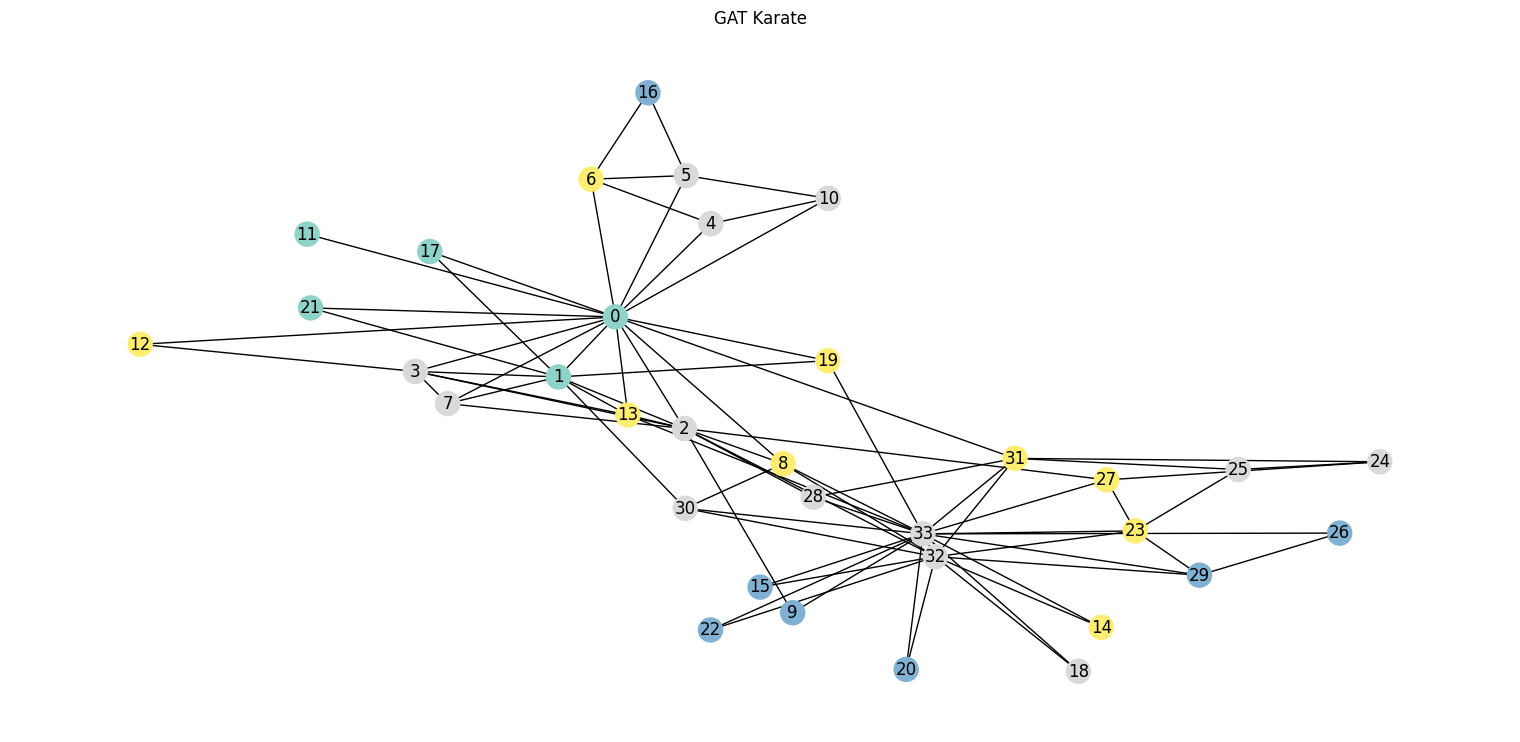

{'Number of Communities': 4,
 'Average Community Size': 8.5,
 'Modularity': -0.07193455894754595,
 'Coverage': 0.28205128205128205,
 'Performance': 0.6809269162210339}

In [104]:
model.eval()
with torch.no_grad():
    z, _, _ = model(data.x, data.edge_index)
    embeddings = z.cpu().numpy()

from sklearn.cluster import KMeans

num_communities = 4  # Set the number of communities
kmeans = KMeans(n_clusters=num_communities)

community_labels = kmeans.fit_predict(embeddings)


plot_communities(g_karate, community_labels, title="GAT Karate")

# Calculate metrics for Louvain
community_metrics(g_karate, dict(zip(range(data.x.shape[0]), community_labels)))
